In [1]:
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
from pathlib import Path

In [2]:
part_path = Path("part-1")
part_path.mkdir(exist_ok=True)

raw_path = Path(f"{part_path}/raw")
raw_path.mkdir(exist_ok=True)

processed_path = Path(f"{part_path}/processed")
processed_path.mkdir(exist_ok=True)

submission_path = Path(f"{part_path}/submission")
submission_path.mkdir(exist_ok=True)

In [27]:
df_train = pd.read_csv(f"{processed_path}/train-embeddings.csv")
df_test = pd.read_csv(f"{processed_path}/test-embeddings.csv")

In [ ]:
from ast import literal_eval
import numpy as np
df_train["embedding"] = df_train.embedding.apply(literal_eval).apply(np.array)


In [31]:
df_train["embedding"].values

array([array([-0.04209324, -0.02419882, -0.04274046, ..., -0.04031938,
              -0.04175764, -0.01195558], shape=(1536,))               ,
       array([-0.04209324, -0.02419882, -0.04274046, ..., -0.04031938,
              -0.04175764, -0.01195558], shape=(1536,))               ,
       array([-0.04209324, -0.02419882, -0.04274046, ..., -0.04031938,
              -0.04175764, -0.01195558], shape=(1536,))               ,
       ...,
       array([-0.01456979,  0.00350134, -0.01028352, ..., -0.00714378,
              -0.04416799, -0.00371888], shape=(1536,))               ,
       array([-0.01456979,  0.00350134, -0.01028352, ..., -0.00714378,
              -0.04416799, -0.00371888], shape=(1536,))               ,
       array([-0.01064207, -0.01903666,  0.02276907, ...,  0.01159189,
              -0.01676243, -0.02809345], shape=(1536,))               ],
      shape=(2387,), dtype=object)

In [35]:
X = list(df_train["embedding"].values)
y = df_train["weight_a"].to_numpy()

In [38]:
X[0]

array([-0.04209324, -0.02419882, -0.04274046, ..., -0.04031938,
       -0.04175764, -0.01195558], shape=(1536,))

In [36]:
# from sklearn.model_selection import GridSearchCV
# import lightgbm as lgb

# # Define the parameter grid
# param_grid = {
#     'num_leaves': [31, 50, 100],
#     'max_depth': [-1, 5, 10],  # -1 means no limit
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200, 300],
#     'min_child_samples': [20, 50, 100],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5]
# }
# param_grid_small = {
#     'num_leaves': [31, 50],
#     'learning_rate': [0.01, 0.1],
#     'n_estimators': [100, 200],
#     'subsample': [0.8, 1.0]
# }

# # Initialize LightGBM model
# lgb_model = lgb.LGBMRegressor(
#     objective='regression',
#     metric='mse',
#     force_col_wise=True,
#     random_state=42
# )

# # Initialize GridSearchCV
# grid_search = GridSearchCV(
#     estimator=lgb_model,
#     param_grid=param_grid_small,
#     cv=5,
#     scoring='neg_mean_squared_error',
#     n_jobs=-1,  # Use all CPU cores
#     verbose=2
# )

# # Perform grid search
# grid_search.fit(X, y)

# # Print results
# print("\nBest parameters found:")
# print(grid_search.best_params_)
# print(f"\nBest MSE: {-grid_search.best_score_:.4f}")

# # Get the best model
# best_model = grid_search.best_estimator_

# # Make predictions on test set using best model
# X_test = df_test[features].to_numpy()
# test_predictions = best_model.predict(X_test)
# test_predictions = pd.Series(test_predictions).round(6).clip(0)

# # Save feature importance plot for best model
# import matplotlib.pyplot as plt

# feature_importance = pd.DataFrame({
#     'feature': features,
#     'importance': best_model.feature_importances_
# })
# feature_importance = feature_importance.sort_values('importance', ascending=True)

# plt.figure(figsize=(12, 8))
# feature_importance.plot.barh(x='feature', y='importance', legend=False)
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance (Best Model)')
# plt.tight_layout()
# plt.show()

In [37]:
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import KFold

lgb_train_data = lgb.Dataset(X, label=y)

# Define parameters
params = {
    "objective": "regression",
    "metric": "mse",
    "force_col_wise": True,
    "num_leaves": 30,
    # "min_data_in_leaf": 20,  # Helps prevent overfitting
    # "max_bin": 255,  # Reduces complexity
    # "learning_rate": 0.01,  # Smaller learning rate for better control
    # "min_gain_to_split": 0.1,  # Prevents unnecessary splits
    # "lambda_l1": 0.1,  # L1 regularization
    # "lambda_l2": 0.1,  # L2 regularization
}

# Perform 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Create training and validation datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    # Train model
    model = lgb.train(
        params, 
        train_data, 
        valid_sets=[val_data],
        # num_boost_round=1000,
        # early_stopping_rounds=50,
        # verbose_eval=False
    )

    # Make predictions and calculate MSE
    y_pred = model.predict(X_val)
    mse = np.mean((y_val - y_pred) ** 2)
    cv_scores.append(mse)

# Calculate mean and std of MSE scores
cv_scores = np.array(cv_scores)
mean_mse = cv_scores.mean()
std_mse = cv_scores.std()

print(f"Cross-validation MSE: {mean_mse:.4f} (+/- {std_mse:.4f})")

TypeError: only integer scalar arrays can be converted to a scalar index

In [8]:
# Train model on the entire dataset
model = lgb.train(
    params,
    lgb_train_data,
)

[LightGBM] [Info] Total Bins 5165
[LightGBM] [Info] Number of data points in the train set: 2387, number of used features: 23
[LightGBM] [Info] Start training from score 0.546016


In [9]:
X_test = df_test[features].to_numpy()

lgb_test_data = lgb.Dataset(X_test)

test_predictions = model.predict(X_test)
test_predictions = pd.Series(test_predictions.tolist()).round(6).clip(0, 0.999999)

In [10]:
# Check if any predictions are >= 1
if (test_predictions >= 1).any():
    print("Warning: Found predictions >= 1")
    print("Max prediction value:", test_predictions.max())
else:
    print("All predictions are < 1")


All predictions are < 1


<Figure size 1200x800 with 0 Axes>

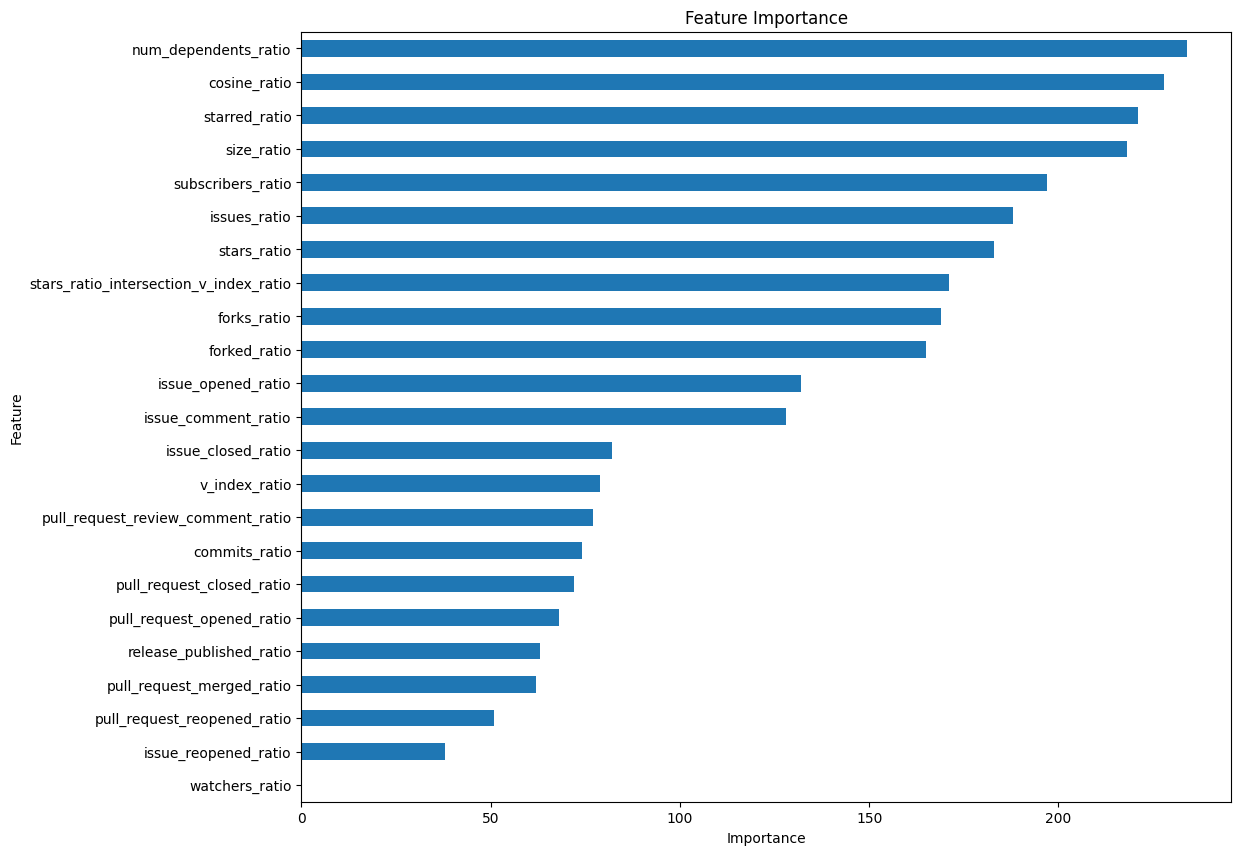

In [11]:
import matplotlib.pyplot as plt

importance = model.feature_importance()

# Create DataFrame in Pandas
feature_importance = pd.DataFrame({"feature": features, "importance": importance.tolist()})

# Sort by importance in ascending order
feature_importance = feature_importance.sort_values(by="importance", ascending=True)

# Set figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Plot horizontal bar chart
feature_importance.plot.barh(x="feature", y="importance", legend=False, figsize=(12, 10))

# Improve layout
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [35]:
import datetime
submission_path = Path(f"{part_path}/submission")

df_submission = df_test[["id"]].copy()  # Select "id" column
df_submission["pred"] = test_predictions  # Add predictions column

# Create filename with timestamp and MSE
filename = f"{submission_path}/submission_{datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}-mse_{mean_mse:.6f}.csv"

# Save to CSV
df_submission.to_csv(filename, index=False)

print(f"Saved file: {filename}")

Saved file: part-2/submission/submission_2025-02-07_23-21-36-mse_0.038831.csv
